# Seq2Seq using Transformers with Attention Mechanism

In [ ]:
# !pip install torchtext==0.6.0 --quiet
# !pip install -U spacy --quiet
# !python -m spacy download en_core_web_trf --quiet
# !python -m spacy download fr_dep_news_trf --quiet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import numpy as np

# from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint
from torch.utils.tensorboard import SummaryWriter
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

# Start processing data using Spacy Tokenizer

In [ ]:
spacy_english = spacy.load('en_core_web_trf')
spacy_french = spacy.load('fr_dep_news_trf')

In [ ]:
# Function to tokenize sentences
def tokenize_french(text):
  return [token.text for token in spacy_french.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

french = Field(tokenize=tokenize_french, lower=True,
               init_token="<sos>", eos_token="<eos>")

english = Field(tokenize=tokenize_english, lower=True,
               init_token="<sos>", eos_token="<eos>")

In [ ]:
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/English_to_French'

fields = {
  'English': ('English', english ),
  'French': ('French', french)
}

train_data, valid_data, test_data = TabularDataset.splits(
    path= FILE_PATH,
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=fields
)

In [ ]:
french.build_vocab(train_data, max_size=10000, min_freq=3)
english.build_vocab(train_data, max_size=10000, min_freq=3)

# Config

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_EPOCHS = 50
learning_rate = 3e-4
PATIENCE = 5

BATCH_SIZE = 32
# VALID_BATCH_SIZE = 8
EMBEDING_SIZE = 512
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT= 0.3
MAX_LEN = 100
FORWARD_EXPANSION = 4
SOURCE_PADDING_INDX = english.vocab.stoi["<pad>"]

SOURCE_VOCAB_SIZE = len(english.vocab)
TARGET_VOCAB_SIZE = len(french.vocab)

# Construct a Transformer architecture

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out


#Setting up before traning

In [ ]:
# writer = SummaryWriter("runs/loss_plot")
# step = 0

train_loader, valid_loader, test_loader = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.English),
    # sort=False,
    device=device,
)


model = Transformer(
    EMBEDING_SIZE,
    SOURCE_VOCAB_SIZE,
    TARGET_VOCAB_SIZE,
    SOURCE_PADDING_INDX,
    NUM_HEADS,
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    FORWARD_EXPANSION,
    DROPOUT,
    MAX_LEN,
    device,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=PATIENCE, verbose=True
)

criterion = nn.CrossEntropyLoss(ignore_index=SOURCE_PADDING_INDX)

# Training and validating

### Here we implement a class called EarlyStopping to store the checkpoint which has best train & valid loss. In addition, it would decrease the chance our model to be overfittiing by using the early stopping mechanism.

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                ''
                'avg_train_losses': avg_train_losses,
                'avg_valid_losses': avg_valid_losses,
                }, self.path)
        self.val_loss_min = val_loss

In [ ]:
import os

load_model = True
train_model = False
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/English_to_French/transfomers-checkpoint_adam.pt'
epoch_len = len(str(NUM_EPOCHS))

start_epoch = 1
last_epoch = 0
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

early_stopping = EarlyStopping(patience=PATIENCE,
                               verbose=True,
                               path=checkpoint_path)

if load_model:
    if not os.path.isfile(checkpoint_path):
        print(f"Not found the model checkpoint. Please check if the checkpoint's name is correct.")
        raise SystemExit
    else:
        print(f"Loading checkpoint . . . .")
        
        checkpoint = torch.load(checkpoint_path, map_location=device)   
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        last_epoch = checkpoint['epoch']
        avg_train_losses = checkpoint['avg_train_losses']
        avg_valid_losses = checkpoint['avg_valid_losses'] 

        start_epoch = last_epoch + 1

        print(f"Checkpoint is successfully loaded . . . .")
        print(f'Last Epoch - {last_epoch:>{epoch_len}} / {NUM_EPOCHS:>{epoch_len}}')
        print(f'train_loss: {avg_train_losses[-1]:.5f} ' + f'valid_loss: {avg_valid_losses[-1]:.5f}')
    

if train_model:
    for epoch in range(start_epoch, NUM_EPOCHS + 1):
        
        print(f'Epoch - {epoch:>{epoch_len}} / {NUM_EPOCHS:>{epoch_len}}')
        
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch_indx, batch in enumerate(train_loader):
            source_sentence = batch.English.to(device)
            target_sentence = batch.French.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(source_sentence, target_sentence[:-1, :])
            output = output.reshape(-1, output.shape[2])
            target_sentence = target_sentence[1:].reshape(-1)

            # calculate the loss
            loss = criterion(output, target_sentence)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            source_sentence = batch.English.to(device)
            target_sentence = batch.French.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(source_sentence, target_sentence[:-1, :])
            output = output.reshape(-1, output.shape[2])
            target_sentence = target_sentence[1:].reshape(-1)
            # calculate the loss
            loss = criterion(output, target_sentence)
            # record validation loss
            valid_losses.append(loss.item())

        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        # Update the scheduler after validate
        scheduler.step(valid_loss)
        
        print_msg = ( f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


Loading checkpoint . . . .
Checkpoint is successfully loaded . . . .
Last Epoch - 34 / 50
train_loss: 0.73101 valid_loss: 0.86001


# Translate a sentence using the model

In [ ]:
import json

english_sentences = []
origin_target_sentence = []
translated_sentences = []

print("Start translating . . . .")

model.eval() # prep model for evaluation
for indx, batch in enumerate(test_loader):
    source_sentence = batch.English.to(device)
    target_sentence = batch.French.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(source_sentence, target_sentence[:-1, :])

    # source_sentence shape [max sentence length in batch, batch size] (batch_size = 32)
    # source_indx shape [batch size, max sentence length in batch]
    source_indx = torch.transpose(source_sentence, 0, 1)

    # output shape [max sentence length in batch, batch size, embedding size/vocab size]
    output_indx = torch.argmax(output, dim=2)

    # output indx shape [max sentence length in batch, batch size]
    output_indx = torch.transpose(output_indx, 0, 1)

    # target_indx shape [batch size, max sentence length in batch]
    target_indx = torch.transpose(target_sentence, 0, 1)

    # Creating a list of source sentences
    for item in source_indx:
        sentence = []
        temp = [english.vocab.itos[indx] for indx in item]
        for token in temp:
            if token == '<sos>':
                continue
            elif token == '<eos>':
                break
            sentence.append(token)
        english_sentences.append(sentence)

    # Creating a list of target sentences
    for item in target_indx:
        sentence = []
        temp = [french.vocab.itos[indx] for indx in item]
        for token in temp:
            if token == '<sos>':
                continue
            elif token == '<eos>':
                break
            sentence.append(token)
        origin_target_sentence.append(sentence)

    # Creating a list of translation sentences
    for item in output_indx:
        sentence = []
        temp = [french.vocab.itos[indx] for indx in item]
        for token in temp:
            if token == '<eos>':
                break
            sentence.append(token)
        translated_sentences.append(sentence)

print("Finish translation . . . .")


result_dict = {"references": origin_target_sentence,
               "candidate": translated_sentences,}

with open('/content/drive/MyDrive/Colab Notebooks/English_to_French/tranformers_adam_translation.txt', 'w') as file:
    file.write(json.dumps(result_dict))

Start translating . . . .
Finish translation . . . .


### Print a pair of [target, output] sentence.

In [ ]:
print("===============================================")
print("First 10 source/target/output sentences")
print("===============================================")

for i in range(10):
    print("Source sentence: ", english_sentences[i])
    print("Target sentence: ", origin_target_sentence[i])
    print("Output sentence: ", translated_sentences[i])
    print()

print("===============================================")
print("Last 10 source/target/output sentences")
print("===============================================")

for i in range(9, 0, -1):
    print("Source sentence: ", english_sentences[-i])
    print("Target sentence: ", origin_target_sentence[-i])
    print("Output sentence: ", translated_sentences[-i])
    print()


First 10 source/target/output sentences
Source sentence:  ['they', 'refused', '.']
Target sentence:  ['elles', 'ont', 'refusé', '.']
Output sentence:  ['elles', 'ont', 'refusé', '.']

Source sentence:  ['she', 'cried', '.']
Target sentence:  ['elle', 'pleurait', '.']
Output sentence:  ['elle', 'pleura', '.']

Source sentence:  ['they', 'sweated', '.']
Target sentence:  ['elles', 'ont', '<unk>', '.']
Output sentence:  ['ils', 'ont', '<unk>', '.']

Source sentence:  ['keep', 'quiet', '.']
Target sentence:  ['restez', 'tranquilles', '.']
Output sentence:  ['restez', 'tranquille', '!']

Source sentence:  ['stay', 'calm', '.']
Target sentence:  ['reste', 'calme', '.']
Output sentence:  ['reste', 'calme', '.']

Source sentence:  ['check', 'this', '.']
Target sentence:  ['vérifie', 'ça', '.']
Output sentence:  ['vérifie', 'ça', '.']

Source sentence:  ['everybody', 'waited', '.']
Target sentence:  ['tout', 'le', 'monde', 'a', 'attendu', '.']
Output sentence:  ['tout', 'le', 'monde', 'attendit

# Loading result dictionary. Then, write the dictionary to a text file.

### Calculating BLEU score for adamW optimizer

In [ ]:
from torchtext.data.metrics import bleu_score

# Loading the dictionary of adamW optimizer
# Load the dictionary and evaluate using Blue score function from torchtext
with open('/content/drive/MyDrive/Colab Notebooks/English_to_French/tranformers_adamW_translation.txt', 'r') as file:
    data_adamW = file.read()

load_dict_adamW = json.loads(data_adamW)

candidate_corpus_adamW = load_dict_adamW["candidate"] # translated sentences
references_corpus_adamW  = load_dict_adamW["references"] # target sentences

result_adamW = bleu_score(candidate_corpus_adamW, references_corpus_adamW)
print(f"Transfomers model using adamW: {result_adamW*100:.2f}")

Transfomers model using adamW: 62.31


### Calculating BLEU score for adam optimizer

In [ ]:
# Loading the dictionary of adamW optimizer
# Load the dictionary and evaluate using Blue score function from torchtext
with open('/content/drive/MyDrive/Colab Notebooks/English_to_French/tranformers_adam_translation.txt', 'r') as file:
    data_adam = file.read()

load_dict_adam = json.loads(data_adam)

candidate_corpus_adam = load_dict_adam["candidate"] # translated sentences
references_corpus_adam  = load_dict_adam["references"] # target sentences

result_adam = bleu_score(candidate_corpus_adam, references_corpus_adam)
print(f"Transfomers model using adam: {result_adam*100:.2f}")

Transfomers model using adam: 62.15


# Plot the training and validation loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Define a function to plot training and validatinon 
def plot_train_valid_loss(train_losss, valid_loss, num_epoch, title):
    epochs = range(1, num_epoch+1)
    plt.plot(epochs, train_losss, 'g', label='Training loss')
    plt.plot(epochs, valid_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### AdamW optimizer

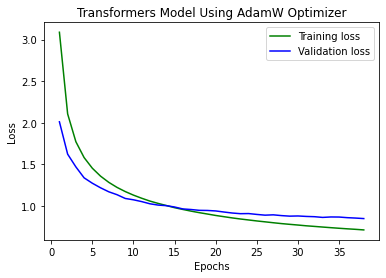

In [ ]:
train_loss_adamW = np.array([3.08814887440639, 2.1067220093026333, 1.772756225835939, 1.582227386660904,
                    1.4541211260716442, 1.3588595464041358, 1.2843318116809674, 1.2238066534764371,
                    1.1737283017833222, 1.1307437409394183, 1.0933403596462992, 1.0593105730740164,
                    1.0313169315698658, 1.0055868736886786, 0.9797598639299513, 0.9587514709605862,
                    0.9385353693293657, 0.9201283180279288, 0.9035227638748493, 0.8864100495149733,
                    0.8716734431472867, 0.8570570847343819, 0.8439668688395245, 0.832241660169503,
                    0.8203949393470761, 0.8098204829190907, 0.7989457808465128, 0.7886194394486635,
                    0.7797398456376091, 0.7712856811550465, 0.7622117660185586, 0.7548582451003283,
                    0.7471356549424681, 0.7396379926185376, 0.7325266350920384, 0.725799903804474,
                    0.719740145131644, 0.712706272949574])

valid_loss_adamW = np.array([2.0118256664015557, 1.623118104939035, 1.4700909707498464, 1.3386105956927024,
                    1.273852112514725, 1.218844823607113, 1.1708835560984516, 1.1360583596325093,
                    1.0907849474031417, 1.074612036537386, 1.0530423307027974, 1.0268231604268643,
                    1.0110890035855098, 1.0042263990325788, 0.9879100084956226, 0.964911198789739,
                    0.9578541111207833, 0.9481106379318759, 0.9464908309538724, 0.940762226807398,
                    0.9277643157484753, 0.915801284743137, 0.9077986401178364, 0.9092145664770095,
                    0.8988234662944502, 0.890003707999523, 0.8939221547492432, 0.8846361792912683,
                    0.8782152468932348, 0.8803294501886559, 0.8748819897517914, 0.8715776502000395,
                    0.8630332873492944, 0.868361811440282, 0.8674212653997383, 0.8598890941325432,
                    0.8551069950796867, 0.849012408860177])

epoch_adamW = 38

plot_train_valid_loss(train_loss_adamW, valid_loss_adamW, epoch_adamW, "Transformers Model Using AdamW Optimizer")

### Adam optimizer

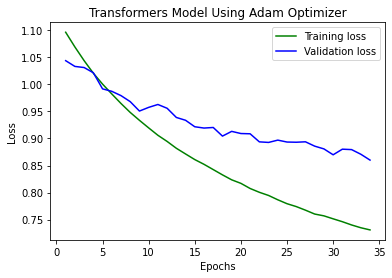

In [ ]:
train_loss_adam = np.array([1.0962135185958886, 1.0690176398225641, 1.043760088267114, 1.0205020824545308,
                            1.0003859314117354, 0.9822227863044392, 0.9645689216702573, 0.9480710115871931,
                            0.9334573440585542, 0.9194889211582269, 0.9058410720002313, 0.8944761936782826,
                            0.8818442067998623, 0.871330413264543, 0.8609492647563398, 0.8521961183984753,
                            0.8424663936319622, 0.8327269685594176, 0.823565607569237, 0.8170283618183272,
                            0.8075449883998165, 0.8005136332953507, 0.7946642099242461, 0.7866703817417264,
                            0.7794365143426034, 0.7741362030870519, 0.7674904080236007, 0.7603262320703823,
                            0.7569965264695858, 0.7515112436312413, 0.7461843040066692, 0.7401674621259635,
                            0.7350247390839735, 0.7310114845995478])

valid_loss_adam = np.array([1.0436926481936581, 1.0330715932915553, 1.031011297728846, 1.0213718123340434,
                            0.9915881821366607, 0.9870772678778255, 0.9791129194539319, 0.9679939356006559,
                            0.9506204568514625, 0.9574136318730526, 0.962746062131093, 0.9557458413646086, 
                            0.938793063218042, 0.9335522441047571, 0.921588310724182, 0.9191993642157327,
                            0.920256038886819, 0.9043399798522664, 0.9130768499087766, 0.9090849306631175,
                            0.9086058772761096, 0.89369356876514, 0.8926543751375271, 0.8969004424543329,
                            0.8933630391331101, 0.8930071140681893, 0.8937916648192484, 0.8857751890935534,
                            0.8806905318153361, 0.8698189085407119, 0.8801705816621554, 0.879402576139933,
                            0.8708359818966662, 0.860005702965898])
# print(train_loss_adamW.size(), valid_loss_adamW.size())
epoch_adam = 34

plot_train_valid_loss(train_loss_adam, valid_loss_adam, epoch_adam, "Transformers Model Using Adam Optimizer")